In [1]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
import sys
import os

folder = '../../../../crispy'
print(folder)
if folder not in sys.path: sys.path.append(folder)

from crispy.params import Params
folder = '../../../crispy'
par = Params(folder)

from crispy.tools.initLogger import getLogger
log = getLogger('crispy')
from crispy.IFS import polychromeIFS
from crispy.IFS import reduceIFSMap
from crispy.tools.imgtools import scale2imgs,bowtie
from crispy.tools.image import Image
from crispy.tools.rotate import rotateCube,shiftCube
from crispy.tools.postprocessing import mf,recenter_offaxis
from crispy.tools.inputScene import adjust_krist_header
from crispy.tools.detector import averageDetectorReadout
from astropy.io import fits
import astropy.units as u
from crispy.tools.postprocessing import construct_mflib,convolved_mf


Populating the interactive namespace from numpy and matplotlib
../../../../crispy


In [2]:
lamc=660.
BW = 0.18
par.nonoise=True
sampling=2.0
par.timeframe=1000
par.Nreads = par.timeframe/300
par.PCmode=False
par.lenslet_sampling=1./sampling
folder = '/Users/mrizzo/IFS/OS5_SIM_'+str(sampling)
offaxis_psf_filename='/Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits'
OS5_files = '/Users/mrizzo/IFS/OS5/with_lowfc/'

try:
    os.makedirs(folder)
    os.makedirs(folder+'/average')
    os.makedirs(folder+'/detector')  
except OSError:
    pass
par.hdr


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT                                                                         
COMMENT ************************************************************            
COMMENT ********************** General parameters ******************            
COMMENT ************************************************************            
COMMENT                                                                         
NLENS   =                  108 / # lenslets across array                        
PITCH   =             0.000174 / Lenslet pitch (meters)                         
INTERLAC=                    2 / Interlacing                                    
PHILENS =    26.565051177077

In [3]:
# from crispy.unitTests import testCreateFlatfield
# testCreateFlatfield(par,pixsize=0.1,npix = 512,Nspec=45,pixval = 1.,useQE=True)
# from crispy.IFS import reduceIFSMap
# reduceIFSMap(par,par.unitTestsOutputs+'/flatfield.fits')


### Reconstruct the matched filter library as needed

In [4]:
# from crispy.tools.postprocessing import construct_mflib
# construct_mflib(par,offaxis_psf_filename=offaxis_psf_filename,
#                 threshold=0.3,
#                 lamc=lamc,
#                 BW=BW,
#                 outdir=folder+'/average',
#                 trim=30,
#                 IWA=3,
#                 OWA=9,
#                 outname = 'mflib.fits.gz',
#                 order=3)


In [5]:
from crispy.tools.postprocessing import process_SPC_IFS2

signal, noise = process_SPC_IFS2(par,
                    psf_time_series_folder=OS5_files,
                    offaxis_psf_filename=offaxis_psf_filename,
                    xshift=0.0,yshift=0.0,
                    lamc=lamc,BW=BW,n_ref_star_imgs=30,
                    tel_pupil_area=3.650265060424805*u.m**2,
                    IWA = 3,OWA = 9,
                    pp_fact = 1.00,
                    RDI=False,
                    mflib=folder+'/average/mflib.fits.gz',
                    subtract_ref_psf=True,
                    outdir_time_series = folder,
                    outdir_detector=folder+'/detector',
                    outdir_average=folder+'/average',
                    process_cubes=False, # this only needs to be turned to True once
                    process_offaxis_files=False,
                    process_detector=True,
                    take_averages=True,
                    normalize_contrast=False)

crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/with_lowfc/os5_spc_001.fits
crispy - INFO - X,Y Shift in px in original cubes: 0.00, 0.00
crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/with_lowfc/os5_spc_031.fits
crispy - INFO - Apply detector readout on os5_spc_001_refstar_IFS.fits
crispy - INFO - Read data from HDU 1 of /Users/mrizzo/IFS/OS5_SIM_2.0/os5_spc_001_refstar_IFS.fits
crispy - INFO - Writing data to /Users/mrizzo/IFS/OS5_SIM_2.0/detector/os5_spc_001_refstar_IFS_detector.fits
crispy - INFO - Apply detector readout on os5_spc_002_refstar_IFS.fits
crispy - INFO - Read data from HDU 1 of /Users/mrizzo/IFS/OS5_SIM_2.0/os5_spc_002_refstar_IFS.fits
crispy - INFO - Writing data to /Users/mrizzo/IFS/OS5_SIM_2.0/detector/os5_spc_002_refstar_IFS_detector.fits
crispy - INFO - Apply detector readout on os5_spc_003_refstar_IFS.fits
crispy - INFO - Read data from HDU 1 of /Users/mrizzo/IFS/OS5_SIM_2.0/os5_spc_003_refstar_IFS.fits
crispy - INFO - Writing data t

In [6]:
signal

array([ 6.6498136 ,  6.21634899,  5.94396813,  5.91751804,  6.06610884,
        6.13801473,  6.1105213 ,  6.05040125,  5.98055011,  5.90732527,
        5.87545543,  5.89153165,  5.88827902,  5.83536595,  5.72872594,
        5.61114434,  5.55085103,  5.53494518,  5.55120311])

In [7]:
noise

[0.7175028776197776,
 0.46977324643692447,
 0.39293206023473809,
 0.36469638776605362,
 0.35905109961967313,
 0.38076984127446106,
 0.41007251014081159,
 0.41469497411204675,
 0.39746475773049761,
 0.38662143684966371,
 0.43710780897879542,
 0.50416837371562939,
 0.5856498728149101,
 0.63777696499784253,
 0.63275115380639357,
 0.59770488955260803,
 0.61427217663747635,
 0.73105798590885984,
 0.92412753497112188]

In [8]:
np.savetxt(folder+"/average/signal.txt",signal)
np.savetxt(folder+"/average/noise.txt",noise)


crispy - INFO - Reduced cube will have 19 wavelength bins


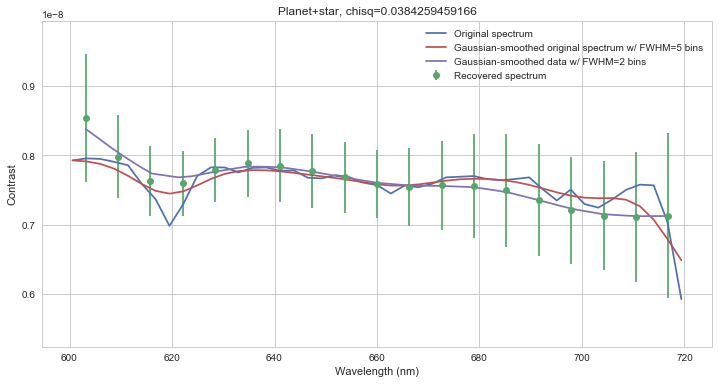

In [9]:
from crispy.tools.postprocessing import SNR_spectrum
from crispy.tools.reduction import calculateWaveList
signal = np.loadtxt(folder+"/average/signal.txt")
noise = np.loadtxt(folder+"/average/noise.txt")
ratio = np.loadtxt(folder+"/average/ratio.txt")
lam_midpts,junk = calculateWaveList(par,method='optext')
wavelist = lamc*np.linspace(1.-BW/2.,1.+BW/2.,45)
ratio_out = SNR_spectrum(lam_midpts,signal,noise,lam_contrast=wavelist,outfolder=par.exportDir+"/",
             FWHM=2*45./19.,FWHMdata=2,edges=1,ymargin=0.25,ratio = None)
#np.savetxt(folder+"/average/ratio.txt",ratio_out)



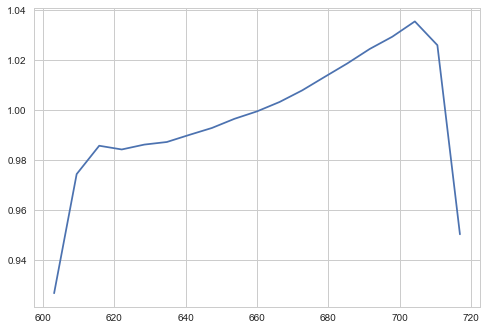

In [10]:
plt.plot(lam_midpts,ratio_out)


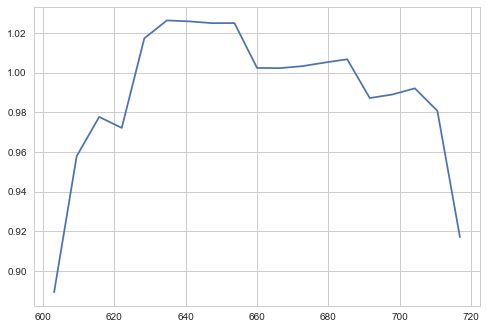

In [11]:
# from crispy.tools.inputScene import calc_contrast_Bijan
plt.plot(lam_midpts,ratio)
# np.savetxt(folder+"/average/ratio.txt",ratio)


<Container object of 3 artists>

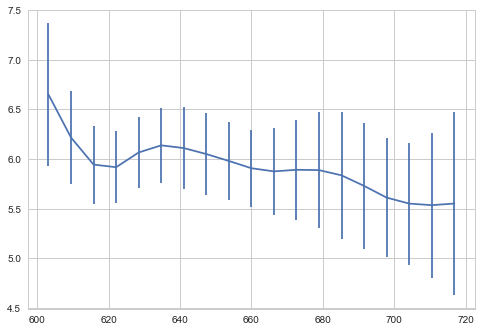

In [12]:
plt.errorbar(lam_midpts,signal,yerr=noise)